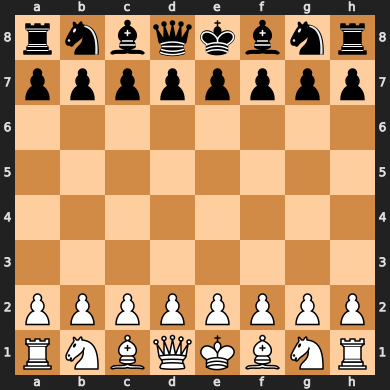

In [22]:
import chess
import json
import os
import tempfile
from concurrent.futures import ThreadPoolExecutor
from stockfish import Stockfish
import chess.pgn
import chess.svg
import cairosvg
import base64
import random
from PIL import Image
board = chess.Board()
board

The chess module comes with a very handy board visualizer. You can also print a purely textual way of displaying the board


In [23]:
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


## Some Handy Functions

In [24]:
board.legal_moves

<LegalMoveGenerator at 0x25f586ad550 (Nh3, Nf3, Nc3, Na3, h3, g3, f3, e3, d3, c3, b3, a3, h4, g4, f4, e4, d4, c4, b4, a4)>

In [25]:
board.is_checkmate()

False

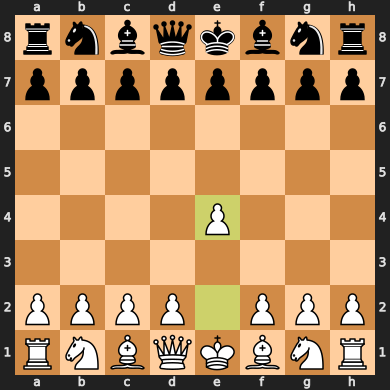

In [26]:
#Making moves!
board.push_san("e4")
board

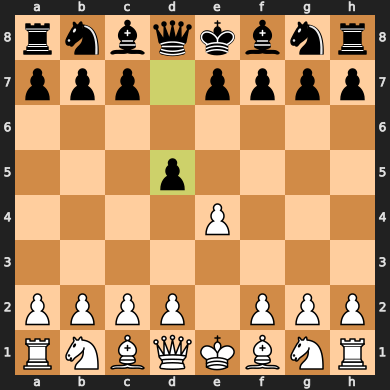

In [27]:
board.push_san("d7d5")
board

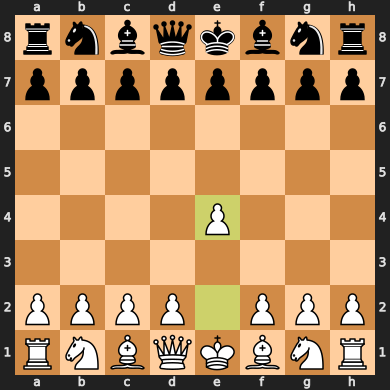

In [28]:
board.pop()
board

In [29]:
#FEN is one way to represent a game state
#https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation
board.fen()

'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'

In [30]:
stock_fish_path = r"stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe"

In [31]:
from stockfish import Stockfish
import random
random.seed(42)
stockfish1=Stockfish(stock_fish_path)
stockfish1.set_depth(10)#How deep the AI looks
stockfish1.set_skill_level(20)#Highest rank stockfish
stockfish1.get_parameters()

{'Write Debug Log': 'false',
 'Contempt': 0,
 'Min Split Depth': 0,
 'Threads': 1,
 'Ponder': 'false',
 'Hash': 16,
 'MultiPV': 1,
 'Skill Level': 20,
 'Move Overhead': 30,
 'Minimum Thinking Time': 20,
 'Slow Mover': 80,
 'UCI_Chess960': 'false',
 'UCI_LimitStrength': 'false',
 'UCI_Elo': 1350}

In [32]:


stockfish2=Stockfish(stock_fish_path)
stockfish2.set_depth(20)#How deep the AI looks
stockfish2.set_skill_level(20)#Highest rank stockfish
stockfish2.get_parameters()

{'Write Debug Log': 'false',
 'Contempt': 0,
 'Min Split Depth': 0,
 'Threads': 1,
 'Ponder': 'false',
 'Hash': 16,
 'MultiPV': 1,
 'Skill Level': 20,
 'Move Overhead': 30,
 'Minimum Thinking Time': 20,
 'Slow Mover': 80,
 'UCI_Chess960': 'false',
 'UCI_LimitStrength': 'false',
 'UCI_Elo': 1350}

In [33]:
board.fen()

'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'

In [34]:
# Get top moves and pick one at random
stockfish1.set_fen_position(board.fen())
top_moves = stockfish1.get_top_moves(5)
type(top_moves[0])

dict

In [35]:
top_moves_list = []
for i in range(5):
    top_moves_list.append(top_moves[i]['Move'])
top_moves_list

['d7d5', 'e7e5', 'c7c5', 'd7d6', 'e7e6']

### Dataset Structure

```json
{
    "State": {
        "Image state": "<Base64-encoded PNG image of the board>",
        "Fen notation": "<FEN string of the current board>",
        "Pgn notation": "<PGN string of the game>"
    },
    "player_to_play": <bool>,  // False for White, True for Black
    "Best_5_moves": [
        "<Move 1>",
        "<Move 2>",
        "<Move 3>",
        "<Move 4>",
        "<Move 5>"
    ]
}
```


In [36]:


def play_stockfish_game(index, stockfish_path):
    # Initialize stockfish engines inside this function for isolation
    stockfish1 = Stockfish(path=stockfish_path)
    stockfish1.set_depth(10)#How deep the AI looks
    stockfish1.set_skill_level(20)#Highest rank stockfish
    
    
    
    stockfish2 = Stockfish(path=stockfish_path)
    stockfish2.set_depth(20)#How deep the AI looks
    stockfish2.set_skill_level(20)#Highest rank stockfish
    
    stockfish1.set_position([])  # Start with initial position
    board = chess.Board()

    moves = 0
    max_moves = random.randint(1, 50)
    while moves < max_moves:
        top_moves_count = random.randint(3, 8)
        legal_moves = list(board.legal_moves)
        if not legal_moves:
            break

        if random.random() < 0.1:
            chosen_move = random.choice(legal_moves)
            board.push(chosen_move)
        else:
            stockfish1.set_fen_position(board.fen())
            top_moves = stockfish1.get_top_moves(top_moves_count)
            if not top_moves:
                chosen_move = random.choice(legal_moves)
            else:
                chosen_move = random.choice(top_moves)['Move']
            board.push_san(chosen_move)

        moves += 1
        if moves >= max_moves:
            break

        top_moves_count = random.randint(3, 8)
        legal_moves = list(board.legal_moves)
        if not legal_moves:
            break

        if random.random() < 0.1:
            chosen_move = random.choice(legal_moves)
            board.push(chosen_move)
        else:
            stockfish1.set_fen_position(board.fen())
            top_moves = stockfish1.get_top_moves(top_moves_count)
            if not top_moves:
                chosen_move = random.choice(legal_moves)
            else:
                chosen_move = random.choice(top_moves)['Move']
            board.push_san(chosen_move)

        moves += 1

    player_to_play = 0 if max_moves % 2 == 0 else 1

    stockfish2.set_fen_position(board.fen())
    final_moves = stockfish2.get_top_moves(5)
    top_moves_list = [m['Move'] for m in final_moves] if final_moves else []

    game = chess.pgn.Game()
    node = game
    for move in board.move_stack:
        node = node.add_variation(move)
    pgn_str = str(game)

    svg_data = chess.svg.board(board=board)
    png_data = cairosvg.svg2png(bytestring=svg_data.encode('utf-8'))
    png_base64 = base64.b64encode(png_data).decode('utf-8')

    result = {
        "State": {
            "Image state": png_base64,
            "Fen notation": board.fen(),
            "Pgn notation": pgn_str
        },
        "player_to_play": bool(player_to_play),
        "Best_5_moves": top_moves_list
    }

    return result

def generate_data_points_for_thread(start_index, end_index, stockfish_path, output_file):
    """Generate a portion of data points and save to output_file in NDJSON format."""
    with open(output_file, 'w', encoding='utf-8') as f:
        for i in range(start_index, end_index):
            data_point = play_stockfish_game(i, stockfish_path)
            f.write(json.dumps(data_point) + '\n')

def create_ndjson_dataset(total_data_points=10000, filename='chess_data.ndjson', num_threads=8, stockfish_path='path_to_stockfish'):
    # Divide total_data_points among threads
    chunk_size = total_data_points // num_threads
    remainder = total_data_points % num_threads

    futures = []
    temp_files = []

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        start = 0
        for t in range(num_threads):
            end = start + chunk_size + (1 if t < remainder else 0)
            # Create a temporary file for each thread
            temp_fd, temp_path = tempfile.mkstemp(suffix='.ndjson')
            os.close(temp_fd)  # Close file descriptor, will use path directly
            temp_files.append(temp_path)

            futures.append(executor.submit(generate_data_points_for_thread, start, end, stockfish_path, temp_path))
            start = end

    # Wait for all threads to finish
    for f in futures:
        f.result()  # Will raise exceptions if any occurred

    # Concatenate all temporary files into the final file
    with open(filename, 'w', encoding='utf-8') as outfile:
        for tf in temp_files:
            with open(tf, 'r', encoding='utf-8') as infile:
                for line in infile:
                    outfile.write(line)
            # Remove temporary file after merging
            os.remove(tf)
 


In [37]:
create_ndjson_dataset(total_data_points=10, filename='chess_data_3.ndjson', num_threads=16, stockfish_path=stock_fish_path)

In [38]:
filename = r"dataset\chess_data_2.ndjson"

with open(filename, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

# Print the first few entries to check the content
print(data[:5])

[{'State': {'Image state': 'iVBORw0KGgoAAAANSUhEUgAAAYYAAAGGCAIAAADw4rGyAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOydZ1wURx/HZ/caHF26KEURERQFFQt2RY29YNcYu6jEaDBNTdRo8sSosTdiLFGsYBcLohQVCyAIHCC993JwXN3d58WZk3p3XD+Y7ws/sDs783N298fslP8gDg4OAAKBQDQDVN0CVIeXl9epU6c8PT3VLUQTWbp06bFjx6ysrNQtRM2MHTv2wIEDJ0+e7N27t7q1qA0HB4fjx4/PnTtXLaWT1VKqWnBwcHB1dbWxsVG3EE3Ew8Oje/fu+vr66haiTjw9PX/44QeCIHAcNzU1VbcctWFsbOzk5FRZWXnt2jXVl646SzI3N7exsamrq8vOzhYIBCortznOzs4AgI8fP2IYpkYZZmZmXbt2ra6uzs3NVZcSOp3u6OhYUVGhltJFkMlke3t7EomUlZXF4/HUosHIyGj8+PFkMvnQoUNv374tKipSiwwAgJ6eXvfu3SsqKurr6+l0eklJibrely5dupiamqanp7NYLJUVqiJLOnDggJubG4lEwjCssrLyu+++y87OVk3RTdiwYQOKohiGVVRUbN68uaCgQPUadHV1d+/e3bt3bxqNhmFYcnKyn5+f6mUMGzbs+++/19fXRxAEwzA+n696DQCA/v37b9++3dDQEADAZDK3bduWmJioehmbNm0aOXIkiUTy8/MjkUiTJk2qr69XvYyRI0f6+/sLm6s4jgsEgvXr16enp6teyeDBg728vAiCYDKZO3fujIuLU025KupLMjIyevv27YkTJ54/f25sbLx161bVlNscCoUSGBj4+vVrU1PTHTt2qEXDt99+279//6KiohMnTjx9+lT4NqoYOp3u7+9PIpGuXLkSHh5Oo9FUrwEAYGho+Msvv9BotKCgoBs3btBotB07dpBIJNUrefjwYW5urkAg